# Imports

In [14]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from tqdm import tqdm
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
from scipy.fft import fft
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# Dataset Class

In [7]:
class DDoSDataset(Dataset):
    def __init__(self, split):
        if (split == "train"):
            self.df_data = pd.concat([pd.read_csv("/home/appuser/data/train/SCLDDoS2024_SetA_events_extended.csv"), pd.read_csv("/home/appuser/data/train/SCLDDoS2024_SetB_events_extended.csv")])
        elif (split == "test"):
            self.df_data = pd.read_csv("/home/appuser/data/test/SCLDDoS2024_SetC_events_extended.csv")
        else:
            raise ValueError("Invalid split. Choose 'train' or 'test'.")
        
        self.split = split
        self.check_for_invalid_values()
        
        self.preprocess()
        
    def check_for_invalid_values(self):
        # Check for missing (NaN) values
        missing_values = self.df_data.isna().sum()
        if missing_values.any():
            print("Missing values per column:\n", missing_values)
        else:
            print("No missing values in the dataframe.")
        
        # Check for infinite values
        infinite_values = self.df_data.isin([np.inf, -np.inf]).sum()
        if infinite_values.any():
            print("Infinite values per column:\n", infinite_values)
        else:
            print("No infinite values in the dataframe.")
        
    def preprocess(self, undersample = False, sample_factor = 4):
        X = self.df_data.iloc[:, :-1]  # Features
        y = self.df_data.iloc[:, -1]   # Labels

        if y.dtype == 'object':
            self.label_encoder = LabelEncoder()
            y = self.label_encoder.fit_transform(y)
        else:
            self.label_encoder = None
            
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
        # Convert to tensors
        self.features = torch.tensor(X, dtype=torch.float32).to("cuda")
        self.labels = torch.tensor(y, dtype=torch.long).to("cuda")

        if undersample and self.split == "train":
            # Undersample the majority class (label=0)
            class_0_indices = np.where(self.labels.cpu().numpy() == 0)[0]
            class_1_indices = np.where(self.labels.cpu().numpy() == 1)[0]
            class_2_indices = np.where(self.labels.cpu().numpy() == 2)[0]

            # Randomly undersample the majority class
            num_class_1_samples = sample_factor*(len(class_0_indices) + len(class_2_indices))  # Same number as the minority class
            class_1_indices_undersampled = np.random.choice(class_1_indices, num_class_1_samples, replace=False)

            # Concatenate indices of class 1, 2, and undersampled class 0
            undersampled_indices = np.concatenate([class_0_indices, class_1_indices_undersampled, class_2_indices])

            # Subset the dataset to include only the sampled indices
            self.features = self.features[undersampled_indices]
            self.labels = self.labels[undersampled_indices]
            
        if self.split == "train":
            features_cpu = self.features.cpu().numpy()
            labels_cpu = self.labels.cpu().numpy()

            X_train, X_val, y_train, y_val = train_test_split(
                features_cpu, labels_cpu,
                test_size=0.2,  # 20% validation
                stratify=labels_cpu,  # preserve class distribution
                random_state=42
            )
            
            self.train_features = torch.tensor(X_train, dtype=torch.float32).to("cuda")
            self.train_labels = torch.tensor(y_train, dtype=torch.long).to("cuda")

            self.val_features = torch.tensor(X_val, dtype=torch.float32).to("cuda")
            self.val_labels = torch.tensor(y_val, dtype=torch.long).to("cuda")
            

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Fully Connected Classifier

In [8]:
# This a really simple Fully Connected classifier to try weighing the loss function as well as experimenting with data augmentation
class FullyConnectedClassifier(nn.Module):
    def __init__(self, input_size, num_classes, num_heads=4, attention_dim=128):
        super(FullyConnectedClassifier, self).__init__()
        self.leaky_relu = nn.LeakyReLU()
        self.gelu = nn.GELU()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # 30% dropout
        
        self.init_bn = nn.BatchNorm1d(input_size)
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(256)
        self.bn5 = nn.BatchNorm1d(256)
        self.bn6 = nn.BatchNorm1d(512)
        self.bn7 = nn.BatchNorm1d(512)
        self.bn8 = nn.BatchNorm1d(128)
        self.bn9 = nn.BatchNorm1d(64)
        
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)  # Residual connection
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 256)  # Residual connection 
        self.fc6 = nn.Linear(256, 512)
        self.fc7 = nn.Linear(512, 512)  # Residual connection
        self.fc8 = nn.Linear(512, 128)
        self.fc9 = nn.Linear(128, 64)  
        self.fc10 = nn.Linear(64, 32)
        self.fc11 = nn.Linear(32, num_classes)
        
        self.fch1 = nn.Linear(512, 1024)
        self.fch2 = nn.Linear(1024, 1024)
        self.fch3 = nn.Linear(1024, 2048)
        self.fch4 = nn.Linear(2048, 2048)
        self.fch5 = nn.Linear(2048, 1024)
        self.fch6 = nn.Linear(1024, 512)
        
        self.bnh1 = nn.BatchNorm1d(1024)
        self.bnh2 = nn.BatchNorm1d(1024)
        self.bnh3 = nn.BatchNorm1d(2048)
        self.bnh4 = nn.BatchNorm1d(2048)
        self.bnh5 = nn.BatchNorm1d(1024)
        self.bnh6 = nn.BatchNorm1d(512)
        
        
        
        # Self-attention layers
        self.attn1 = nn.MultiheadAttention(embed_dim=64, num_heads=num_heads, batch_first=True)
        self.attn2 = nn.MultiheadAttention(embed_dim=128, num_heads=num_heads, batch_first=True)
        self.attn3 = nn.MultiheadAttention(embed_dim=128, num_heads=num_heads, batch_first=True)
        self.attn4 = nn.MultiheadAttention(embed_dim=256, num_heads=num_heads, batch_first=True)
        self.attn5 = nn.MultiheadAttention(embed_dim=256, num_heads=num_heads, batch_first=True)
        self.attn6 = nn.MultiheadAttention(embed_dim=512, num_heads=num_heads, batch_first=True)
        self.attn7 = nn.MultiheadAttention(embed_dim=512, num_heads=num_heads, batch_first=True)
        self.attn8 = nn.MultiheadAttention(embed_dim=128, num_heads=num_heads, batch_first=True)
        self.attn9 = nn.MultiheadAttention(embed_dim=64, num_heads=num_heads, batch_first=True)
        
    def forward(self, x):
        x = self.init_bn(x)
        
        # FC1 with attention
        x = self.bn1(self.leaky_relu(self.fc1(x)))

        # FC2 with attention
        x = self.bn2(self.leaky_relu(self.fc2(x)))

        # FC3 with residual and attention
        x_res = x
        x = self.dropout(self.bn3(self.leaky_relu(self.fc3(x))))
        x, _ = self.attn3(x.unsqueeze(1), x.unsqueeze(1), x.unsqueeze(1))  # Apply attention
        x = x.squeeze(1) + x_res  # Residual connection

        # FC4 with attention
        x = self.bn4(self.leaky_relu(self.fc4(x)))

        # FC5 with residual and attention
        x_res = x
        x = self.dropout(self.bn5(self.leaky_relu(self.fc5(x))))
        x, _ = self.attn5(x.unsqueeze(1), x.unsqueeze(1), x.unsqueeze(1))  # Apply attention
        x = x.squeeze(1) + x_res  # Residual connection

        # FC6
        x = self.bn6(self.leaky_relu(self.fc6(x)))

        # FC7 with residual and attention
        x_res = x
        x = self.dropout(self.bn7(self.leaky_relu(self.fc7(x))))
        x, _ = self.attn7(x.unsqueeze(1), x.unsqueeze(1), x.unsqueeze(1))  # Apply attention
        x = x.squeeze(1) + x_res  # Residual connection
        
        # Go into higher dimensionality
        x = self.bnh1(self.leaky_relu(self.fch1(x)))
        x = self.bnh2(self.leaky_relu(self.fch2(x)))
        x = self.bnh3(self.leaky_relu(self.fch3(x)))
        x = self.bnh4(self.leaky_relu(self.fch4(x)))
        x = self.bnh5(self.leaky_relu(self.fch5(x)))
        x = self.bnh6(self.leaky_relu(self.fch6(x)))
        
        
        # FC8 w
        x = self.bn8(self.leaky_relu(self.fc8(x)))
        
        # FC9 
        x = self.bn9(self.leaky_relu(self.fc9(x)))     

        # Final layers
        x = self.leaky_relu(self.fc10(x))
        x = self.fc11(x)  # No activation (raw logits for CrossEntropyLoss)

        return x

# Transformer-based Classifiers

In [9]:
# Focal loss to compensate for the imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Apply softmax to get probabilities
        probs = F.softmax(inputs, dim=-1)
        
        # Get the probability for the true class (targets)
        probs_true = probs.gather(dim=-1, index=targets.unsqueeze(1))
        
        # Calculate focal loss
        loss = -self.alpha * (1 - probs_true) ** self.gamma * torch.log(probs_true)
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

class DDoSTransformer(nn.Module):
    def __init__(self, input_dim=27, d_model=64, num_heads=8, num_layers=8, d_ff=256, dropout=0.1, num_classes=3):
        super(DDoSTransformer, self).__init__()
        self.input_projection = nn.Linear(input_dim, d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # x shape: (batch_size, 27)
        x = self.input_projection(x).unsqueeze(1)  # -> (batch_size, 1, d_model)
        x = self.transformer_encoder(x)            # -> (batch_size, 1, d_model)
        x = x.squeeze(1)                           # -> (batch_size, d_model)

        return self.classifier(x) 
    
        

class DifferentiableTreeMLP(nn.Module):
    def __init__(self, input_dim, num_layers=3, hidden_dim=256, num_classes=3, dropout=0.1):
        super().__init__()
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = hidden_dim
        self.mlp = nn.Sequential(*layers)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.mlp(x)
        return self.classifier(x)        
        
        
class DDoSFeatureExtractor(nn.Module):
    def __init__(self, input_dim=27, d_model=128, num_heads=8, num_layers=4, d_ff=256, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=num_heads, dim_feedforward=d_ff,
            dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.input_proj(x).unsqueeze(1)     # (batch, 1, d_model)
        x = self.encoder(x).squeeze(1)          # (batch, d_model)
        return x
    
    
class DDoSFeatureExtractorWithHead(nn.Module):
    def __init__(self, input_dim=27, d_model=64, num_heads=8, num_layers=4, d_ff=128, dropout=0.1, num_classes=3):
        super().__init__()
        self.feature_extractor = DDoSFeatureExtractor(input_dim, d_model, num_heads, num_layers, d_ff, dropout)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        features = self.feature_extractor(x)  # (batch, d_model)
        return self.classifier(features)
    
    
    
class DDoSHybridNodeModel(nn.Module):
    def __init__(self, input_dim=27, d_model=1024, num_heads=4, num_layers=4, d_ff=256, dropout=0.1, num_classes=3):
        super().__init__()
        self.feature_extractor = DDoSFeatureExtractor(input_dim, d_model, num_heads, num_layers, d_ff, dropout)
        
        # 2D Convolution Layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),  # First 2D conv layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),  # Pooling layer
            nn.Conv2d(32, 8, kernel_size=(3, 3), padding=1),  # Second 2D conv layer
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))  # Pooling layer
        )
        
        # Calculate the size of the feature map after convolutions and pooling
        # Assuming d_model is a perfect square (e.g., 1024 -> 32x32)
        self.feature_map_size = (d_model // 2) // 2  # After two max poolings, each reduces the size by 2
        
        # Flatten and pass to classifier
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),  # Adjust based on feature map size
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        # Extract features from the Transformer
        x = self.feature_extractor(x)
        
        # Reshape to 2D (d_model/2, d_model/2)
        x = x.view(x.size(0), 1, int(x.size(1) ** 0.5), int(x.size(1) ** 0.5))  # (batch, 1, d_model/2, d_model/2)
        
        # Apply 2D convolution layers
        x = self.conv_layers(x)
        
        # Flatten and predict
        x = torch.flatten(x, start_dim=1)  # Flatten except batch dimension
        x = self.classifier(x)
        
        return x

# Training

In [21]:
# define the run name and log directory, also intialize the TensorBoard writer
run_name = "DDoSTransformer"  
tb_log_dir = f'/home/appuser/src/logs/CustomModels/{run_name}'
writer = SummaryWriter(log_dir=tb_log_dir)


# Initialize the weights to Xavier uniform distribution and zero for biases
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
      
# count the trainable parameters in the model      
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

timestamp = time.strftime("%Y-%m-%d_%H-%M-%S")
filename = f"weights/{run_name}_{timestamp}.pth"


# Create train dataloader and test/val datasets
dataset = DDoSDataset("train")
test_dataset = DDoSDataset("test")

train_dataset = TensorDataset(dataset.train_features, dataset.train_labels)

X_val = dataset.val_features
y_val = dataset.val_labels

X_test = test_dataset.features
y_test = test_dataset.labels

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)


# Initialize the model, you should leave only one of the following lines uncommented at a time (the one you want to use)
model = DDoSTransformer(input_dim=dataset.train_features.shape[1], num_classes=len(dataset.label_encoder.classes_)).to("cuda")
# model = DDoSHybridNodeModel(input_dim=dataset.train_features.shape[1], num_classes=len(dataset.label_encoder.classes_)).to("cuda")
# model = DDoSFeatureExtractorWithHead(input_dim=dataset.features.shape[1], num_classes=len(dataset.label_encoder.classes_)).to("cuda")
# model = FullyConnectedClassifier(input_size=dataset.features.shape[1], num_classes=len(dataset.label_encoder.classes_)).to("cuda")
model.apply(init_weights)


# Use the AdamW optimizer with weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Use Focal Loss with alpha and gamma parameters or the CrossEntropyLoss with class weights
loss_fn = FocalLoss(alpha=0.1, gamma=4.0, reduction='mean')
loss_fn = nn.CrossEntropyLoss(weight=(torch.tensor([3.0, 1.0, 3.0]).to("cuda")))
num_epochs = 100

# Get the total number of trainable parameters in the model
total_params = count_parameters(model)
print(f"Total number of parameters: {total_params}")


# Train the model
save_frequency = 5
model.train()
train_losss = []
for epoch in range(num_epochs):
    epoch_loss = 0
    pbar = tqdm(enumerate(train_loader),total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for i, data in pbar:
        inputs, labels = data

        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_postfix(loss=epoch_loss/(i+1))
    train_losss.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}")
    
    # Validation and test
    with torch.no_grad():
        model.eval()
        val_outputs = model(X_val)
        _, val_preds = torch.max(val_outputs, 1)
        val_f1_macro = f1_score(y_val.cpu().numpy(), val_preds.cpu().numpy(), average='macro')
        
        y_pred = []
        y_test = []
        pbar = tqdm(enumerate(test_loader),total=len(test_loader))
        for i, data in pbar:
            inputs, labels = data
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_test.extend(labels.cpu().numpy())
        test_f1_macro = f1_score(y_test, y_pred, average='macro')
        
        model.train()
        
    writer.add_scalar('validation_macro_F1', val_f1_macro, epoch+1)
    writer.add_scalar('test_macro_F1', test_f1_macro, epoch+1)
    writer.add_scalar('train_loss', epoch_loss/len(train_loader), epoch+1)

    
    if epoch % save_frequency == 0:
        torch.save(model.state_dict(), filename)
        print(f"Model saved at epoch {epoch+1}")

No missing values in the dataframe.
No infinite values in the dataframe.
No missing values in the dataframe.
No infinite values in the dataframe.
Total number of parameters: 406019


Epoch 1/100: 100%|██████████| 414/414 [00:15<00:00, 27.48batch/s, loss=0.391]


Epoch 1/100, Loss: 0.3906


100%|██████████| 254/254 [00:02<00:00, 105.73it/s]


Model saved at epoch 1


Epoch 2/100: 100%|██████████| 414/414 [00:14<00:00, 28.02batch/s, loss=0.321]


Epoch 2/100, Loss: 0.3212


Epoch 3/100: 100%|██████████| 414/414 [00:14<00:00, 27.97batch/s, loss=0.28] 


Epoch 3/100, Loss: 0.2796


Epoch 4/100: 100%|██████████| 414/414 [00:15<00:00, 27.41batch/s, loss=0.243]


Epoch 4/100, Loss: 0.2425


Epoch 5/100: 100%|██████████| 414/414 [00:14<00:00, 27.73batch/s, loss=0.218]


Epoch 5/100, Loss: 0.2181


Epoch 6/100: 100%|██████████| 414/414 [00:14<00:00, 27.96batch/s, loss=0.2]  


Epoch 6/100, Loss: 0.2002


100%|██████████| 254/254 [00:02<00:00, 105.81it/s]


Model saved at epoch 6


Epoch 7/100: 100%|██████████| 414/414 [00:14<00:00, 27.71batch/s, loss=0.189]


Epoch 7/100, Loss: 0.1886


Epoch 8/100: 100%|██████████| 414/414 [00:14<00:00, 27.68batch/s, loss=0.182]


Epoch 8/100, Loss: 0.1815


Epoch 9/100: 100%|██████████| 414/414 [00:14<00:00, 27.63batch/s, loss=0.176]


Epoch 9/100, Loss: 0.1759


Epoch 10/100: 100%|██████████| 414/414 [00:15<00:00, 27.42batch/s, loss=0.172]


Epoch 10/100, Loss: 0.1722


Epoch 11/100: 100%|██████████| 414/414 [00:15<00:00, 27.24batch/s, loss=0.169]


Epoch 11/100, Loss: 0.1694


100%|██████████| 254/254 [00:02<00:00, 111.86it/s]


Model saved at epoch 11


Epoch 12/100: 100%|██████████| 414/414 [00:15<00:00, 27.59batch/s, loss=0.166]


Epoch 12/100, Loss: 0.1665


Epoch 13/100: 100%|██████████| 414/414 [00:15<00:00, 27.48batch/s, loss=0.162]


Epoch 13/100, Loss: 0.1621


Epoch 14/100: 100%|██████████| 414/414 [00:15<00:00, 27.58batch/s, loss=0.16] 


Epoch 14/100, Loss: 0.1595


Epoch 15/100: 100%|██████████| 414/414 [00:15<00:00, 27.33batch/s, loss=0.157]


Epoch 15/100, Loss: 0.1566


 33%|███▎      | 83/254 [00:00<00:01, 94.82it/s] 


KeyboardInterrupt: 

# Inference

No missing values in the dataframe.
No infinite values in the dataframe.


100%|██████████| 254/254 [00:02<00:00, 106.64it/s]


Overall accuracy: 0.90
Confusion Matrix:
[[   552    465     38]
 [  4716 115563   5613]
 [    35   2104    913]]
Accuracy for class 'DDoS attack': 0.52
Accuracy for class 'Normal traffic': 0.92
Accuracy for class 'Suspicious traffic': 0.30
Macro-average F1 score: 0.44
Micro-average F1 score: 0.92


<Figure size 800x600 with 0 Axes>

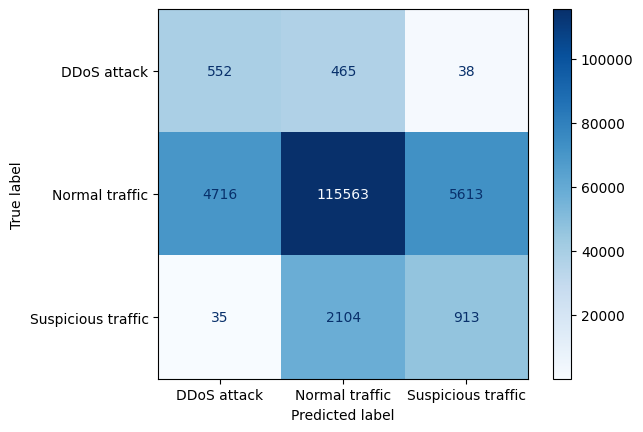

In [22]:
test_dataset = DDoSDataset("test")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=False)

# Be sure to use the same architecture as the one used for training
model = DDoSTransformer(input_dim=dataset.train_features.shape[1], num_classes=len(dataset.label_encoder.classes_)).to("cuda")
# model = DDoSHybridNodeModel(input_dim=dataset.train_features.shape[1], num_classes=len(dataset.label_encoder.classes_)).to("cuda")
# model = DDoSFeatureExtractorWithHead(input_dim=dataset.features.shape[1], num_classes=len(dataset.label_encoder.classes_)).to("cuda")
# model = FullyConnectedClassifier(input_size=dataset.features.shape[1], num_classes=len(dataset.label_encoder.classes_)).to("cuda")

model.load_state_dict(torch.load(filename))
model.to("cuda")
model.eval()

y_pred = []
y_test = []
pbar = tqdm(enumerate(test_loader),total=len(test_loader))
for i, data in pbar:
    inputs, labels = data
    outputs = model(inputs)
    
    _, predicted = torch.max(outputs, 1)
    y_pred.extend(predicted.cpu().numpy())
    y_test.extend(labels.cpu().numpy())
    
# Calculate overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall accuracy: {accuracy:.2f}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
label_encoder = test_dataset.label_encoder  # Assuming label_encoder is available
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Accuracy for class '{class_name}': {class_accuracy[i]:.2f}")

# Calculate F1 score (macro-average and weighted)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"Macro-average F1 score: {f1_macro:.2f}")
print(f"Micro-average F1 score: {f1_weighted:.2f}")

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.label_encoder.classes_)
disp.plot(cmap='Blues', values_format="d")
plt.imshow(np.log1p(cm), cmap='Blues')  # Log transform for better visualization
plt.show()